In [66]:
# Install Packages
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install keras
!pip install tensorflow
!pip install seaborn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


Skipping file with ValueError: 39_1_20170116174525125.jpg.chip.jpg
Skipping file with ValueError: 61_1_20170109150557335.jpg.chip.jpg
Skipping file with ValueError: 61_1_20170109142408075.jpg.chip.jpg


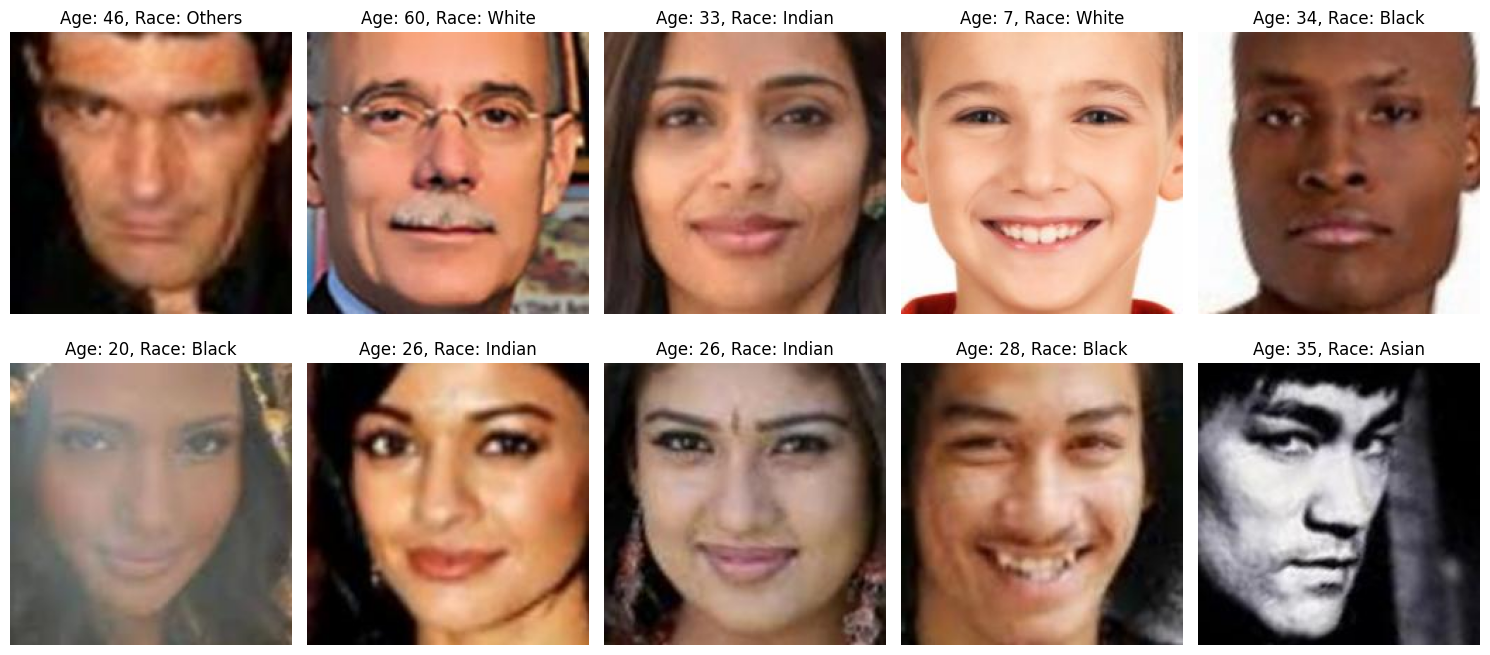

In [67]:
# Importing and visualizing the dataset
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

dataset_path = "UTKFace"

# image_paths, age, gender, race
image_paths = []
age_list = []
gender_list = []
race_list = []

race_dict = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

gender_dict = {
    0: 'Male',
    1: 'Female',
}

for images in os.listdir(dataset_path):
    if images.endswith(".jpg"):
        try:
            image_name = os.path.basename(images)
            image_path = os.path.join(dataset_path, image_name)
            image_labels = image_name.split('_')

            age = int(image_labels[0])
            gender = int(image_labels[1])
            race = int(image_labels[2])

            age_list.append(age)
            gender_list.append(gender)
            race_list.append(race)
            image_paths.append(image_path)

        except ValueError:
            print(f"Skipping file with ValueError: {image_name}")
        except IndexError:
            print(f"Skipping file with IndexError: {image_name}")
        except Exception as e:
            print(f"Skipping file with unknown error '{e}': {image_name}")   

## Displaying random images with ethnicity and age
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))
for i in range(10):
    idx = random.randint(0, len(image_paths) - 1)
    
    img_path = image_paths[idx]
    age = age_list[idx]
    race = race_list[idx]
    
    ax = axes[i // 5, i % 5]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Age: {age}, Race: {race_dict.get(race, 'Unknown')}")
    ax.axis('off')

plt.tight_layout()
plt.show()


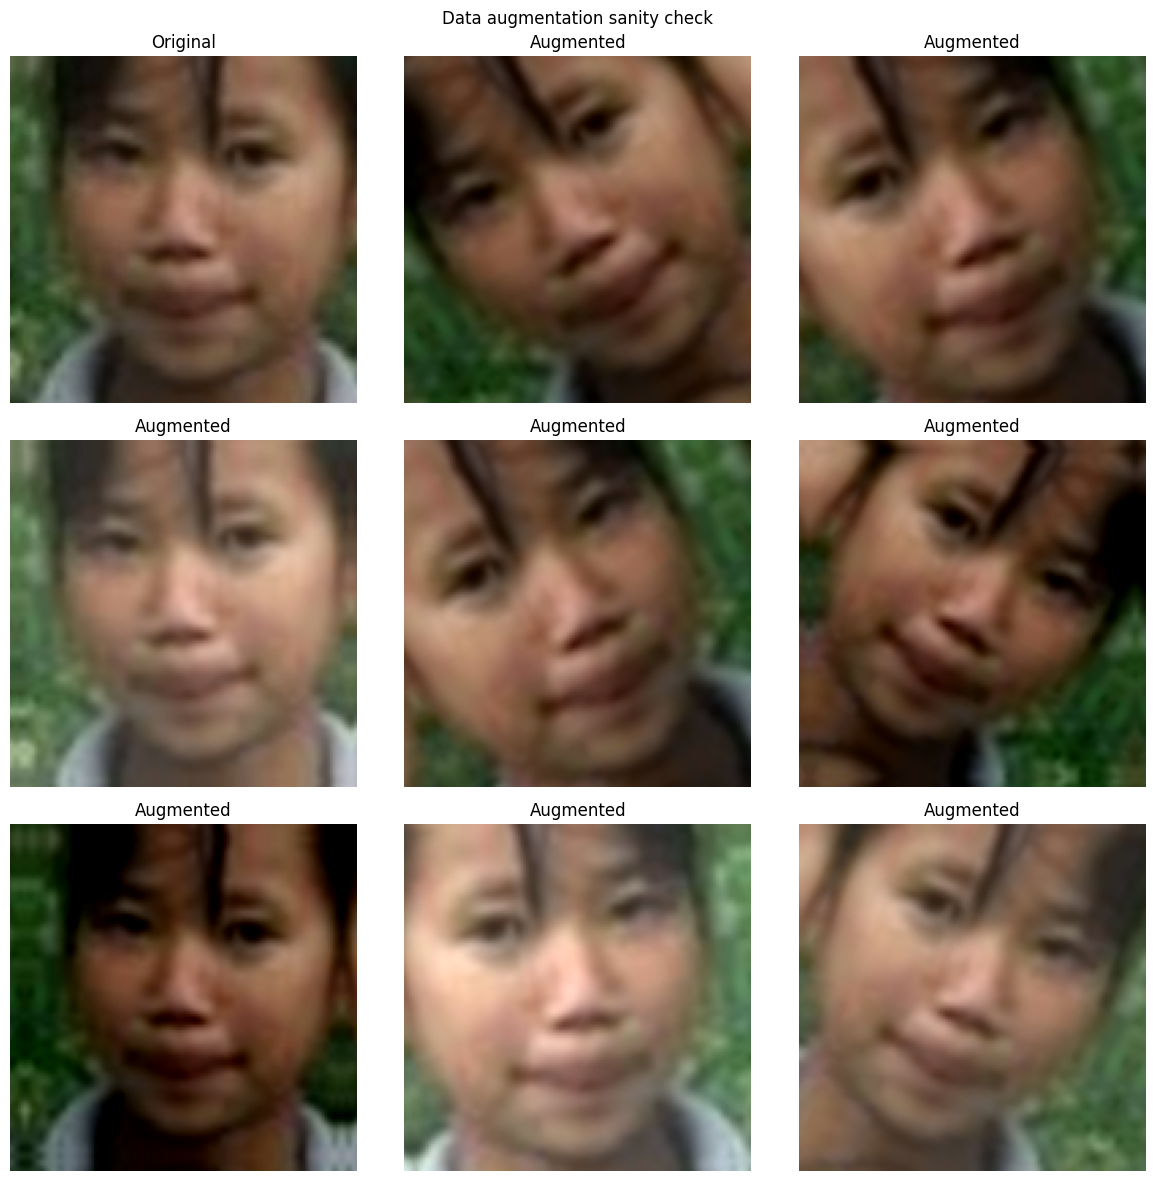

In [68]:
# Data Augmentation
import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

IMG_SIZE = 128
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(factor=0.2),
        layers.RandomContrast(factor=0.2),
    ],
    name="data_augmentation"
)

img = tf.io.read_file(image_paths[0])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
img_batch = tf.expand_dims(img, 0)

plt.figure(figsize=(12, 12))
ax = plt.subplot(3, 3, 1)
plt.imshow(img.numpy().astype("uint8")) 
plt.title("Original")
plt.axis("off")

for i in range(8):
    ax = plt.subplot(3, 3, i + 2) 
    augmented_batch = data_augmentation(img_batch, training=True)
    augmented_img = augmented_batch[0]
    
    plt.imshow(augmented_img.numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.suptitle("Data augmentation sanity check", fontsize=12)
plt.tight_layout()
plt.show()

In [69]:
from sklearn.model_selection import train_test_split
# image_paths, age_list, gender_list, race_list

max_age = 116.0 
age_list_normalized = [age / max_age for age in age_list]

# Test-Val_test split: 60% Train, 20% Val, 20% Test

# 60% Train, 40% Temp
(train_paths, temp_paths, 
 train_ages, temp_ages, 
 train_gender, temp_gender,
 train_races, temp_races) = train_test_split(
    image_paths, 
    age_list_normalized, 
    gender_list,
    race_list,
    test_size=0.4, 
    random_state=42, 
    stratify=race_list 
)

# Temp to 20% Val, 20% Test 
(val_paths, test_paths, 
 val_ages, test_ages, 
 val_gender, test_gender,  
 val_races, test_races) = train_test_split(
    temp_paths, 
    temp_ages,
    temp_gender, 
    temp_races,
    test_size=0.5, 
    random_state=42,
    stratify=temp_races
)

In [70]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(race_list)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_races  
)

race_weights_dict = dict(zip(classes, weights))
race_weights_dict = {int(i): float(j) for i, j in race_weights_dict.items()}

print("Class Weights for Ethnicity:")
print(race_weights_dict)

train_race_weights = [race_weights_dict[label] for label in train_races]
val_race_weights = [1.0] * len(val_paths)
test_race_weights = [1.0] * len(test_paths)


Class Weights for Ethnicity:
{0: 0.47041508185877295, 1: 1.0473490427098675, 2: 1.380873786407767, 3: 1.1927044025157232, 4: 2.80256157635468}


In [71]:
IMG_SIZE = 128
BATCH_SIZE = 64
# function for image loading and preprocessing 
def load_preprocess(image_path, age_label, gender_label, race_label, race_weight):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    
    labels = {
        "age_output": age_label,
        "gender_output": gender_label,
        "ethnicity_output": race_label
    }

    weights = {
        "age_output": 1.0,  
        "gender_output": 1.0, 
        "ethnicity_output": race_weight 
    }

    return img, labels

# data loading pipepline
def data_pipeline(paths, ages, gender, races, race_weights, is_training=True):

    df = tf.data.Dataset.from_tensor_slices((paths, ages, gender, races, race_weights))

    df = df.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        df = df.shuffle(buffer_size=1000)
        
    df = df.batch(BATCH_SIZE)
    df = df.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return df

train_df = data_pipeline(train_paths, train_ages, train_gender, train_races, train_race_weights)
val_df = data_pipeline(val_paths, val_ages, val_gender, val_races, val_race_weights, is_training=False)
test_df = data_pipeline(test_paths, test_ages, test_gender, test_races, test_race_weights, is_training=False)

In [72]:
# Model 1:

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Age (Regression)
age_fcl = layers.Dense(64, activation='relu')(x)
age_fcl = layers.Dropout(0.5)(age_fcl)
age_output = layers.Dense(1, activation='sigmoid', name='age_output')(age_fcl)

# Gender (Classification)
gender_fcl = layers.Dense(64, activation='relu')(x)
gender_fcl = layers.Dropout(0.5)(gender_fcl)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_fcl)


# Ethnicity (Classification)
ethnicity_fcl = layers.Dense(64, activation='relu')(x)
ethnicity_fcl = layers.Dropout(0.5)(ethnicity_fcl)
ethnicity_output = layers.Dense(5, activation='softmax', name='ethnicity_output')(ethnicity_fcl)

model = keras.Model(inputs=inputs, outputs=[age_output, gender_output, ethnicity_output])

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ input_layer_16[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │        896 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_24… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_25… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │  4,194,432 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │         65 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │         65 │ dropout_14[0][0]

 Total params: 4,312,903 (16.45 MB)

 Trainable params: 4,312,903 (16.45 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    
    loss={
        'age_output': 'mean_squared_error', 
        'gender_output': 'binary_crossentropy', 
        'ethnicity_output': 'sparse_categorical_crossentropy' 
    },
    
    metrics={
        'age_output': 'mean_absolute_error',
        'gender_output': 'accuracy',
        'ethnicity_output': 'accuracy'
    },
    
    loss_weights={
        'age_output': 1.0, 
        'gender_output': 5.0, 
        'ethnicity_output': 10.0
    }
)

print("Model compiled for 3 outputs.")

Model compiled for 3 outputs.


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='simple_model_v2.keras', monitor='val_loss', save_best_only=True)

# Training
print("Starting training...")
history = model.fit(train_df, epochs=30, validation_data=val_df, callbacks=[early_stopping, model_checkpoint])
print("Training complete.")

# Testing
print("\n--- Evaluating on unseen test data ---")
test_metrics = model.evaluate(test_df)
print(f"Test Metrics: {test_metrics}")

Starting training...
Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 78s 343ms/step - age_output_loss: 0.0645 - age_output_mean_absolute_error: 0.2138 - ethnicity_output_accuracy: 0.3881 - ethnicity_output_loss: 1.6149 - gender_output_accuracy: 0.5226 - gender_output_loss: 0.7162 - loss: 19.7990 - val_age_output_loss: 0.0615 - val_age_output_mean_absolute_error: 0.2138 - val_ethnicity_output_accuracy: 0.4250 - val_ethnicity_output_loss: 1.5779 - val_gender_output_accuracy: 0.5134 - val_gender_output_loss: 0.6929 - val_loss: 19.3066
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 73s 327ms/step - age_output_loss: 0.0472 - age_output_mean_absolute_error: 0.1811 - ethnicity_output_accuracy: 0.4112 - ethnicity_output_loss: 1.5299 - gender_output_accuracy: 0.5154 - gender_output_loss: 0.6949 - loss: 18.8207 - val_age_output_loss: 0.0529 - val_age_output_mean_absolute_error: 0.1979 - val_ethnicity_output_accuracy: 0.4250 - val_ethnicity_output_loss: 1.5570 - val_gender_output_accuracy: 0.5132 - val_gender_o

<Axes: ylabel='Count'>

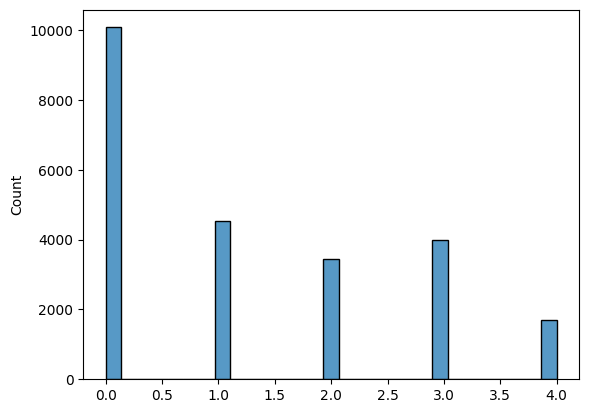

In [ ]:
import seaborn as sns
sns.histplot(race_list)